## Imports

In [1]:
#  Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
#  Train test split
from sklearn.model_selection import train_test_split
#  Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
#  Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

## Data Preprocessing

In [3]:
#  read the dataset
df = pd.read_csv('./datasets/spam.csv', encoding='ISO-8859-1')
#  rename the columns
df = df[['v1','v2']]
df.rename(columns={'v1':'label', 'v2':'message'}, inplace=True)
#  show the first instances
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

### Word Cloud

In [6]:
ham_msg  = df.loc[df['label'] == 'ham']
spam_msg = df.loc[df['label'] == 'spam']

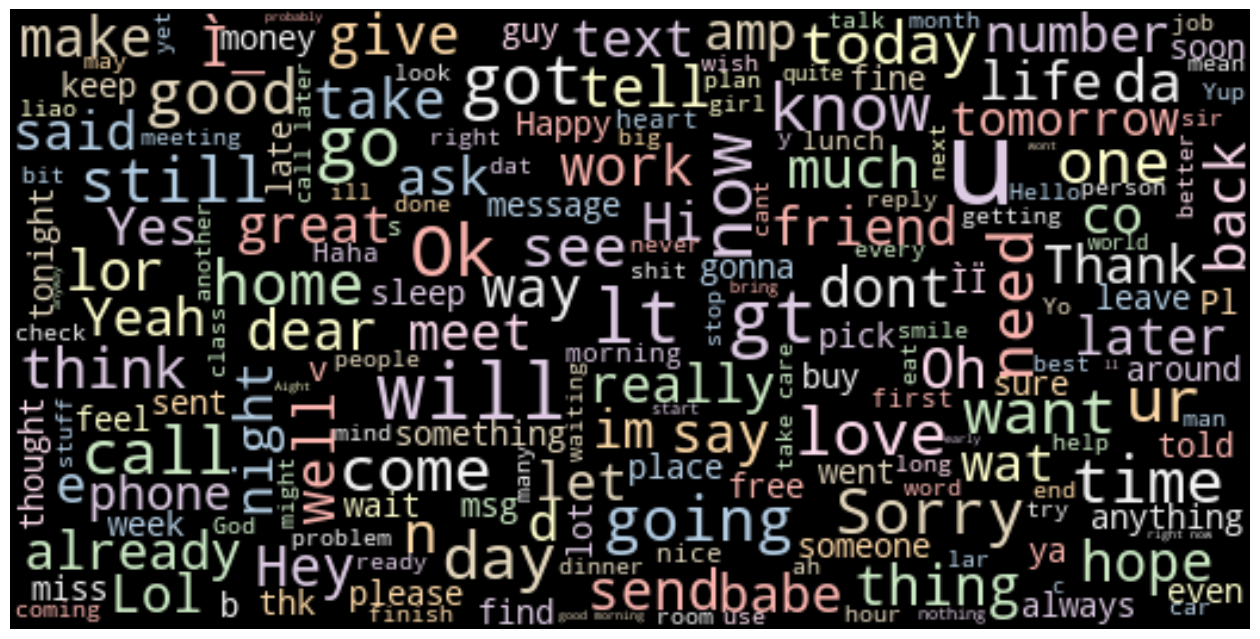

In [7]:
#  Word cloud class 'ham'
ham_msg_text = ' '.join(ham_msg['message'])
ham_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

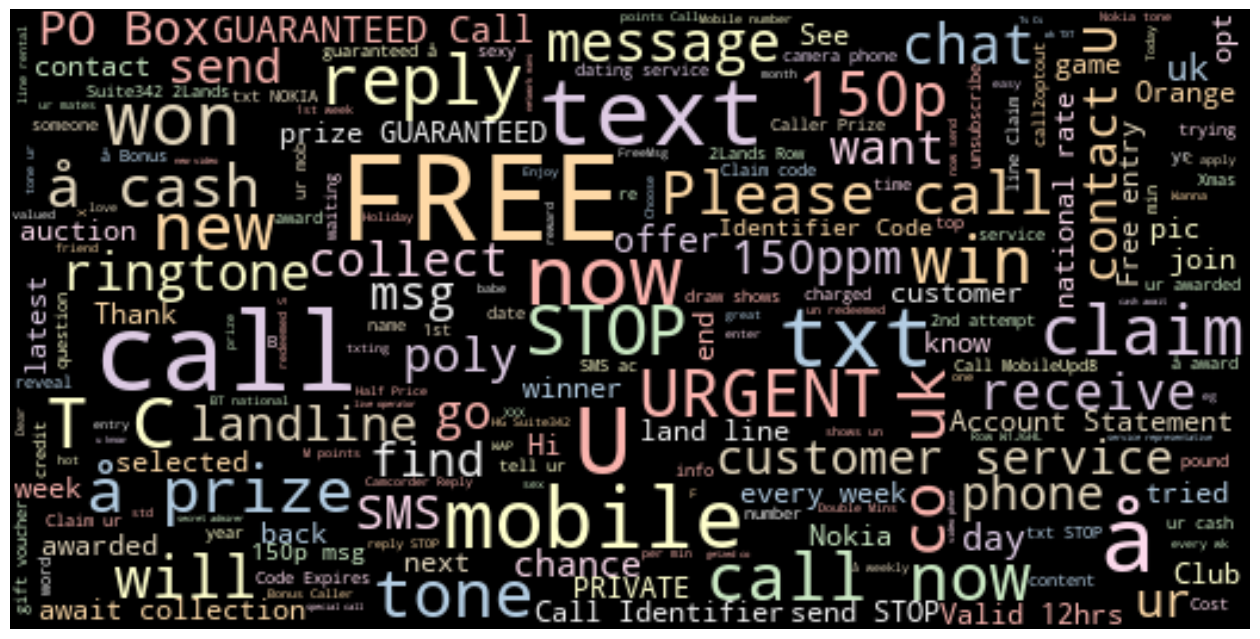

In [8]:
#  Word cloud class 'spam'
spam_msg_text = ' '.join(spam_msg['message'])
spam_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Balancing the Data

Text(0.5, 1.0, 'The distribution of ham and spam messages')

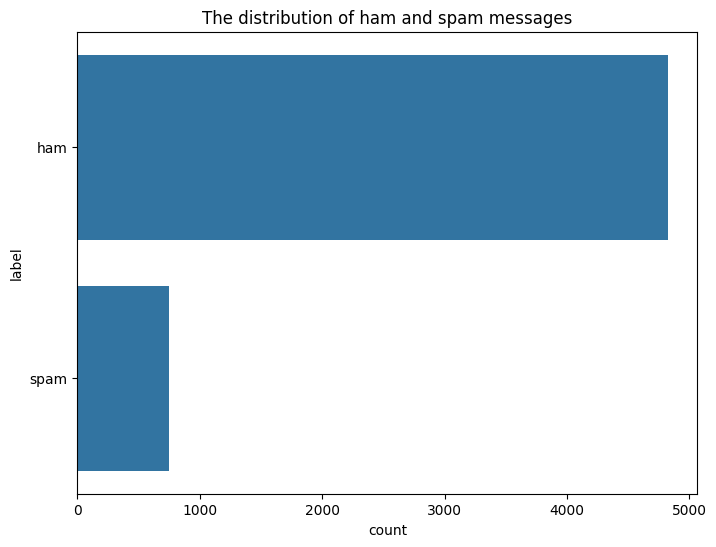

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
plt.title('The distribution of ham and spam messages')

In [10]:
#  downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)

In [11]:
msg_df = pd.concat([ham_msg_df, spam_msg])
msg_df.head()

,label,message
3234,ham,"Yes, princess. Toledo."
3804,ham,Dude while were makin those weirdy brownies my...
2701,ham,"Hiya, sorry didn't hav signal. I haven't seen ..."
2822,ham,Then u ask darren go n pick u lor... But i oso...
5161,ham,Lol no. I just need to cash in my nitros. Hurr...


In [12]:
msg_df.tail()

,label,message
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...
5567,spam,This is the 2nd time we have tried 2 contact u...


Text(0.5, 1.0, 'The distribution of ham and spam messages')

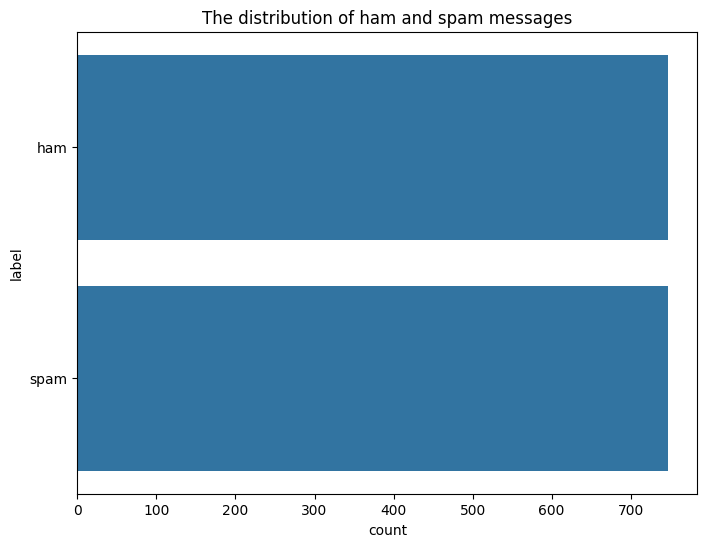

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('The distribution of ham and spam messages')

### Text Preprocessing

Creates two columns in the *dataframe*: one to store the length of each text message and another to store the class label converted to a numeric value (0: ham, 1: spam)

In [15]:
#  Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#  Get the converted numeric label of the data
msg_df['msg_type'] = msg_df['label'].map({'ham':0, 'spam':1})
msg_df.head()

,label,message,text_length,msg_type
3234,ham,"Yes, princess. Toledo.",22,0
3804,ham,Dude while were makin those weirdy brownies my...,88,0
2701,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",169,0
2822,ham,Then u ask darren go n pick u lor... But i oso...,74,0
5161,ham,Lol no. I just need to cash in my nitros. Hurr...,75,0


In [16]:
msg_df.tail()

,label,message,text_length,msg_type
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,1
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,1
5567,spam,This is the 2nd time we have tried 2 contact u...,161,1


### Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(msg_df['message'], msg_df['msg_type'], test_size=0.2, random_state=434)

In [18]:
X_train.tail()

1364    Hey i will be really pretty late... You want t...
1121    Do you want 750 anytime any network mins 150 t...
4458    Welcome to UK-mobile-date this msg is FREE giv...
2900    Ur cash-balance is currently 500 pounds - to m...
5269    If you don't, your prize will go to another cu...
Name: message, dtype: object

In [19]:
y_train.tail()

1364    0
1121    1
4458    1
2900    1
5269    1
Name: msg_type, dtype: int64

### Tokenization

The text of the messages needs to be converted to a numeric representation so that the model can understand them.

The TensorFlow Tokenizer API breaks the sentences into words and encodes them into integers.

The Tokenizer will perform the following preprocessing steps: tokenize at the word level, remove punctuation marks, convert all words to lowercase, convert all words to integers. The following parameters have been defined:
- num_words: number of unique words (vocabulary)
- oov_token: token used to replace words that are not in the vocabulary

In [20]:
#  Defining pre-processing parameters
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' #  out of vocabulary token
vocab_size = 500

In [21]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [22]:
#  Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4054

Each sentence is then represented by a sequence of numbers using the texts_to_sequences method of the Tokenizer object.

Then, each sentence is either padded with the 'pad' token or truncated so that they are all the same length.

The parameters are:
- maxlen: maximum length of all sequences. The *default* value is the length of the longest sentence.
- padding: 'pre' or 'post' (*default*). Pads with 'pad' tokens before ('pre') or after ('post') each sequence.
- truncating: 'pre' or 'post' (*default*). If the length of a sentence is greater than the 'maxlen' value, it is truncated to 'maxlen'. The 'pre' option truncates at the beginning and 'post' truncates at the end of the sequence.

In [23]:
#  Train data
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [24]:
#  Test data
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [25]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


## LSTM Bidirectional Single Layer

In [26]:
embedding_dim = 16
n_lstm = 128
drop_lstm = 0.2

In [27]:
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 bidirectional (Bidirection  (None, 256)               148480    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 156737 (612.25 KB)
Trainable params: 156737 (612.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

## Treinamento do Modelo

EarlyStopping (monitor='val_loss', patience=2) defines that the method will monitor the loss on the validation data, and if the loss is not improved after 2 epochs, then the training model is terminated. This technique helps to avoid overfitting problems.

In [30]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model.fit(training_padded,
                    y_train,
                    epochs = num_epochs,
                    validation_data = (testing_padded, y_test),
                    callbacks = [early_stop],
                    verbose = 2)

Epoch 1/30
38/38 - 4s - loss: 0.6132 - accuracy: 0.6418 - val_loss: 0.5909 - val_accuracy: 0.7926 - 4s/epoch - 111ms/step
Epoch 2/30
38/38 - 1s - loss: 0.2794 - accuracy: 0.8929 - val_loss: 0.1836 - val_accuracy: 0.9398 - 1s/epoch - 32ms/step
Epoch 3/30
38/38 - 1s - loss: 0.2186 - accuracy: 0.9238 - val_loss: 0.1983 - val_accuracy: 0.9365 - 1s/epoch - 30ms/step
Epoch 4/30
38/38 - 1s - loss: 0.2219 - accuracy: 0.9280 - val_loss: 0.2223 - val_accuracy: 0.9231 - 1s/epoch - 30ms/step


Plota gráficos de acurácia e perda

In [31]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6346362590789795)

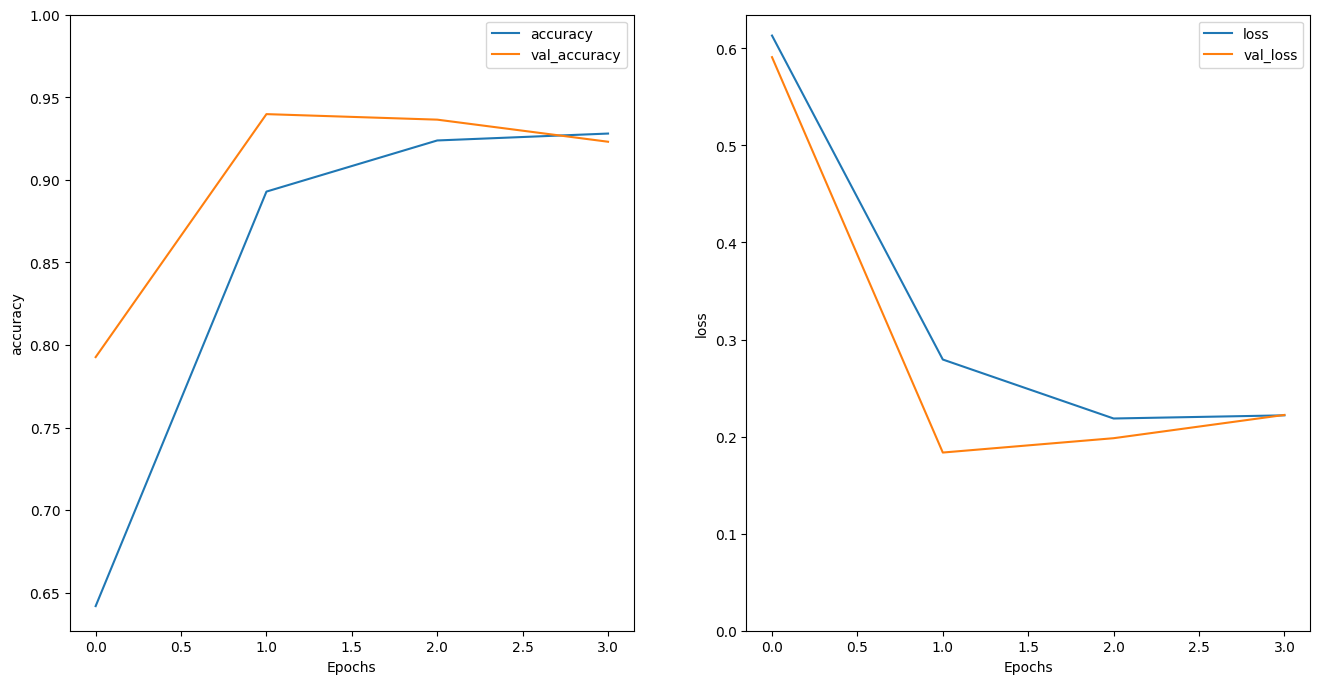

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## Model evaluation

In [33]:
test_loss, test_acc = model.evaluate(testing_padded, y_test)
print(f"LSTM model loss: {test_loss} " )
print(f"LSTM model accuracy: {test_acc*100:0.2f}%" )

10/10 [==============================] - 0s 7ms/step - loss: 0.2223 - accuracy: 0.9231
LSTM model loss: 0.22232048213481903 
LSTM model accuracy: 92.31%


## Prediction

In [34]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
               "Call me","Get this subscription for free!"]

In [35]:
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model.predict(padded))

In [36]:
#  'ham' if predict < 0.5 otherwise 'spam'
predict_spam(predict_msg)

1/1 [==============================] - 1s 510ms/step


array([[0.86706406],
       [0.07337324],
       [0.09625857]], dtype=float32)

## 3 Layers LSTM Bidirectional

In [37]:
model = Sequential([Embedding(vocab_size, embedding_dim,input_length = max_len),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(1, activation='sigmoid')
                    ])


In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 256)           148480    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [39]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [40]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model.fit(training_padded,
                    y_train,
                    epochs = num_epochs,
                    validation_data = (testing_padded, y_test),
                    callbacks = [early_stop],
                    verbose = 2)

Epoch 1/30
38/38 - 15s - loss: 0.4661 - accuracy: 0.7699 - val_loss: 0.2415 - val_accuracy: 0.9231 - 15s/epoch - 395ms/step
Epoch 2/30
38/38 - 7s - loss: 0.1738 - accuracy: 0.9448 - val_loss: 0.1095 - val_accuracy: 0.9732 - 7s/epoch - 191ms/step
Epoch 3/30
38/38 - 7s - loss: 0.1155 - accuracy: 0.9632 - val_loss: 0.0943 - val_accuracy: 0.9632 - 7s/epoch - 189ms/step
Epoch 4/30
38/38 - 7s - loss: 0.0839 - accuracy: 0.9766 - val_loss: 0.0919 - val_accuracy: 0.9666 - 7s/epoch - 185ms/step
Epoch 5/30
38/38 - 7s - loss: 0.0723 - accuracy: 0.9816 - val_loss: 0.1109 - val_accuracy: 0.9666 - 7s/epoch - 187ms/step
Epoch 6/30
38/38 - 7s - loss: 0.0657 - accuracy: 0.9808 - val_loss: 0.0800 - val_accuracy: 0.9666 - 7s/epoch - 190ms/step
Epoch 7/30
38/38 - 7s - loss: 0.0653 - accuracy: 0.9808 - val_loss: 0.1298 - val_accuracy: 0.9632 - 7s/epoch - 191ms/step
Epoch 8/30
38/38 - 7s - loss: 0.0452 - accuracy: 0.9874 - val_loss: 0.1020 - val_accuracy: 0.9565 - 7s/epoch - 187ms/step


(0.0, 0.48714119512587784)

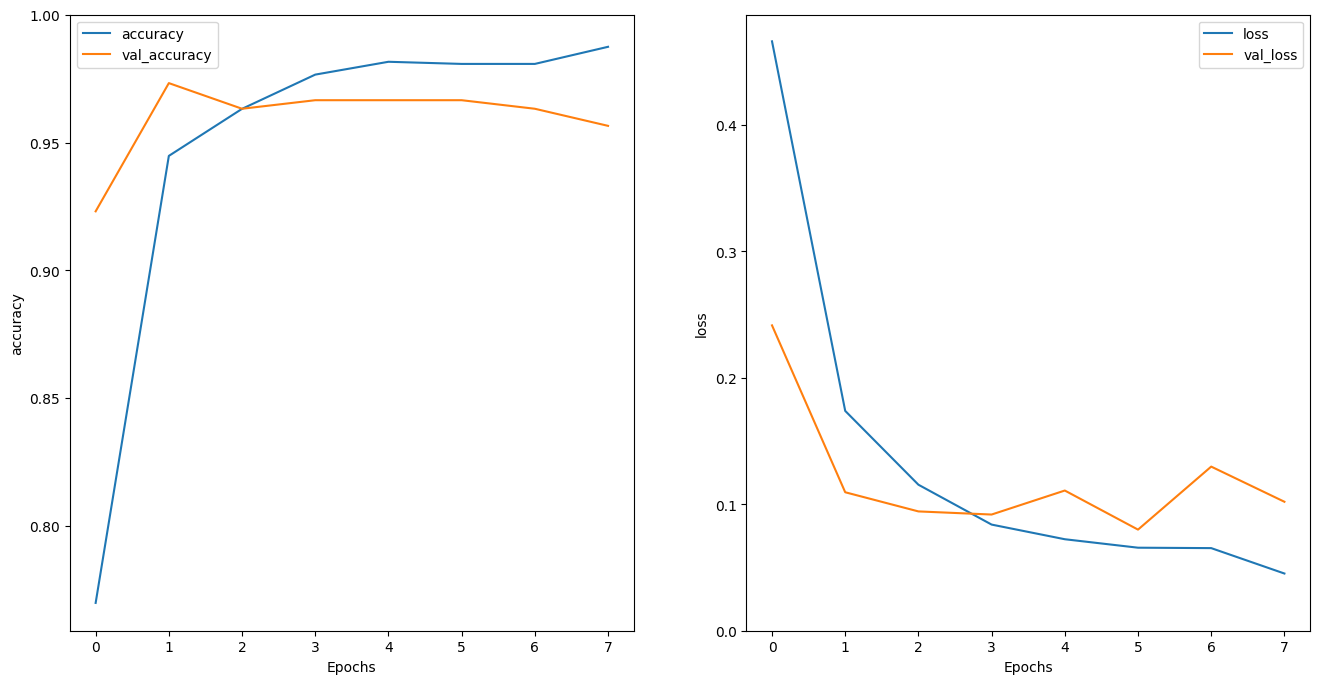

In [41]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [42]:
triple_lstm_test_loss, triple_lstm_test_acc = model.evaluate(testing_padded, y_test)
print(f"LSTM model loss: {triple_lstm_test_loss} " )
print(f"LSTM model accuracy: {triple_lstm_test_acc*100:0.2f}%" )

10/10 [==============================] - 0s 27ms/step - loss: 0.1020 - accuracy: 0.9565
LSTM model loss: 0.10199055820703506 
LSTM model accuracy: 95.65%


In [43]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
               "Call me","Get this subscription for free!"]

#  'ham' if predict < 0.5 otherwise 'spam'
predict_spam(predict_msg)

1/1 [==============================] - 1s 1s/step


array([[0.9929888 ],
       [0.00407563],
       [0.01889074]], dtype=float32)

## Gated Recurrent Unit (GRU)

In [44]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(GRU(128)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               112128    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 120385 (470.25 KB)
Trainable params: 120385 (470.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [47]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model.fit(training_padded,
                    y_train,
                    epochs = num_epochs,
                    validation_data = (testing_padded, y_test),
                    callbacks = [early_stop],
                    verbose = 2)

Epoch 1/30
38/38 - 4s - loss: 0.6632 - accuracy: 0.5900 - val_loss: 0.5775 - val_accuracy: 0.7124 - 4s/epoch - 107ms/step
Epoch 2/30
38/38 - 1s - loss: 0.3346 - accuracy: 0.8787 - val_loss: 0.2760 - val_accuracy: 0.9064 - 1s/epoch - 30ms/step
Epoch 3/30
38/38 - 1s - loss: 0.1669 - accuracy: 0.9523 - val_loss: 0.1338 - val_accuracy: 0.9632 - 1s/epoch - 29ms/step
Epoch 4/30
38/38 - 1s - loss: 0.1150 - accuracy: 0.9632 - val_loss: 0.1011 - val_accuracy: 0.9632 - 1s/epoch - 29ms/step
Epoch 5/30
38/38 - 1s - loss: 0.0858 - accuracy: 0.9707 - val_loss: 0.0806 - val_accuracy: 0.9766 - 1s/epoch - 28ms/step
Epoch 6/30
38/38 - 1s - loss: 0.0698 - accuracy: 0.9782 - val_loss: 0.0699 - val_accuracy: 0.9666 - 1s/epoch - 30ms/step
Epoch 7/30
38/38 - 1s - loss: 0.0606 - accuracy: 0.9824 - val_loss: 0.1566 - val_accuracy: 0.9331 - 1s/epoch - 29ms/step
Epoch 8/30
38/38 - 1s - loss: 0.0551 - accuracy: 0.9808 - val_loss: 0.1012 - val_accuracy: 0.9699 - 1s/epoch - 30ms/step


(0.0, 0.6936142602935433)

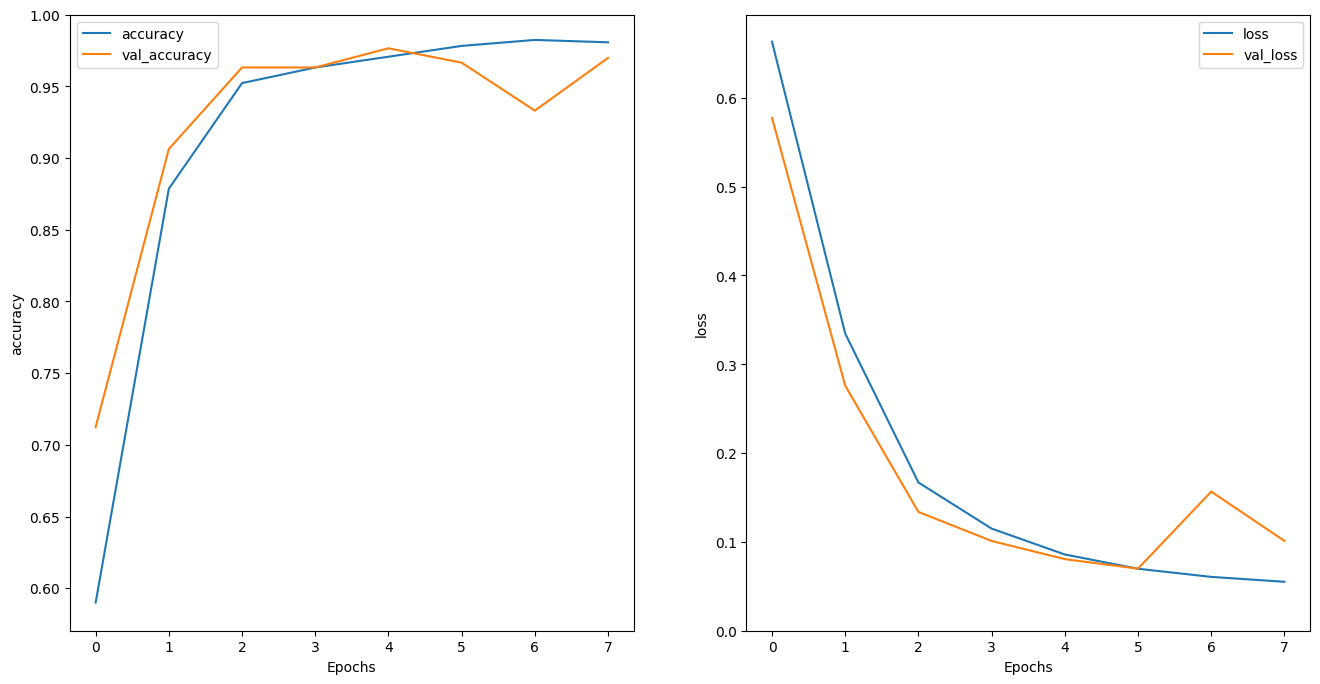

In [48]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [49]:
gru_test_loss, gru_test_acc = model.evaluate(testing_padded, y_test)
print(f"GRU model loss: {gru_test_loss} " )
print(f"GRU model accuracy: {gru_test_acc*100:0.2f}%" )

10/10 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9699
GRU model loss: 0.1011582762002945 
GRU model accuracy: 96.99%


In [50]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
               "Call me","Get this subscription for free!"]

#  'ham' if predict < 0.5 otherwise 'spam'
predict_spam(predict_msg)

1/1 [==============================] - 0s 397ms/step


array([[0.9846559 ],
       [0.01372087],
       [0.25262436]], dtype=float32)

## Results

In [57]:
results = {
    'Model': ['LSTM', 'Stacked LSTM (3 layers)', 'GRU'],
    'Loss': [test_loss, triple_lstm_test_loss, gru_test_loss],
    'Accuracy': [test_acc, triple_lstm_test_acc, gru_test_acc]
}

df_resultados = pd.DataFrame(results)

df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False, ignore_index=1)

df_resultados

,Model,Loss,Accuracy
0,GRU,0.101158,0.969900
1,Stacked LSTM (3 layers),0.101991,0.956522
2,LSTM,0.222320,0.923077


The GRU model achieved the best accuracy, being 1.2% better than the Stacked LSTM model. The loss value for both GRU and Stacked LSTM are equivalent.